<a href="https://colab.research.google.com/github/csch7/CSCI-4170/blob/main/Homework-04/RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From the data, it seems like measurements were taken during 3 different continuous sessions, which happen to be pretty good sizes for training, validation, and test sets.

In [1]:
import numpy as np
import pandas as pd
# import contractions
import re
import torch
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/YoutubeCommentsDataSet.csv")

# Used for balancing the dataset
def load_dataset(dat, tar):
  vals, cts = np.unique(tar, return_counts=True)
  min_val = vals[np.argmin(cts)]
  min_ct = min(cts)
  new_dat = dat[tar == min_val]
  new_tar = tar[tar == min_val]
  for i, v in enumerate(vals):
    if v != min_val:
      indices = list(np.where(tar == v))[0]
      new_ind = np.random.choice(indices, min_ct)
      new_dat = np.append(new_dat, dat[new_ind], axis=0)
      new_tar = np.append(new_tar, tar[new_ind])
  return new_dat, new_tar

  # Function to clean text for sentiment analysis
def clean_text(text):
    text = str(text).lower() # Convert to lowercase
    # text = contractions.fix(text) # Expand contractions
    text = re.sub(r"http\S+|www\.\S+", "", text) # Remove URLs starting with http/https or www
    text = re.sub(r"@\w+", "", text)  # Remove mentions (@usernames) to avoid irrelevant tokens
    text = re.sub(r"[^a-z0-9' ]", "", text) # Remove special characters
    text = re.sub(r"\s+", " ", text).strip() # Remove extra spaces
    return text

# Apply text cleaning function to the "Comment" column before model training
df["Cleaned_Text"] = df["Comment"].apply(clean_text)


Mounted at /content/drive


In [2]:
print(df.count(axis=0))
df.dropna(axis=0, inplace = True)
print(df.count(axis=0))
df = df.drop_duplicates(subset = "Comment")

Comment         18364
Sentiment       18408
Cleaned_Text    18408
dtype: int64
Comment         18364
Sentiment       18364
Cleaned_Text    18364
dtype: int64


In [3]:
# # max_words = 7500

# dat = np.array(df)[:,0]
# str2id = dict()
# n_ids = 1
# max_str = 0
# for i in range(len(dat)):
#   # if(len(str2id.keys() > max_words)): break
#   strs = dat[i].split()
#   if len(strs) > max_str:
#     max_str = len(strs)
#   for s in strs:
#     if s not in str2id.keys():
#       str2id[s] = n_ids
#       n_ids += 1
#     # if(len(str2id.keys() > max_words)): break

# transformed_dat = np.zeros((np.shape(dat)[0], max_str), dtype = np.int32)
# for i in range(len(dat)):
#     strs = dat[i].split()
#     for s in range(100):
#       if(s >= len(strs)):
#         transformed_dat[i, s] = 0
#       else:
#         transformed_dat[i, s] = str2id[strs[s]]
# max_str = 100

# # print(transformed_y)

# vals, idxs, occs = np.unique(ys, return_inverse = True, return_counts = True)
# # print(vals, idxs, occs)

# transformed_dat, ys = load_dataset(transformed_dat, np.array(ys))
# transformed_y = np.zeros((np.shape(transformed_dat)[0]))
# transformed_y[ys == 'positive'] = 2
# transformed_y[ys == 'neutral'] =  1
# transformed_y[ys == 'negative'] = 0

# # transformed_y = np.zeros((np.shape(transformed_dat)[0], 3))
# # transformed_y[ys == 'positive'] = [1,0,0]
# # transformed_y[ys == 'neutral'] =  [0,1,0]
# # transformed_y[ys == 'negative'] = [0,0,1]

# # print(transformed_dat, transformed_y)



In [4]:
from torch import nn

class myRNN(nn.Module):
  def __init__(self, input_dim, embed_dim, hidden_dim, output_dim):
    super(myRNN, self).__init__()
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(input_dim, embed_dim, padding_idx=0)
    self.drop = nn.Dropout(0.3)
    self.rnn = nn.RNN(embed_dim, hidden_dim, nonlinearity='relu', batch_first = True)
    self.final = nn.Linear(hidden_dim, output_dim)
    self.output = nn.Softmax(dim=1)


  def forward(self, x):
    em = self.embed(x)
    dropped = self.drop(em)
    _, res = self.rnn(dropped)
    dropped = self.drop(res)
    final = self.final(dropped[-1])
    return self.output(final)



class myLSTM(nn.Module):
  def __init__(self, input_dim, embed_dim, hidden_dim, output_dim):
    super().__init__()
    self.embed = nn.Embedding(input_dim, embed_dim)
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first = True)
    self.drop = nn.Dropout(0.3)
    self.final = nn.Linear(hidden_dim, output_dim)
    self.output = nn.Softmax(dim=1)


  def forward(self, x):
    em = self.embed(x)
    dropped = self.drop(em)
    _, (res, _) = self.lstm(dropped)
    dropped = self.drop(res)
    final = self.final(dropped[-1])
    return self.output(final)


class myGRU(nn.Module):

  def __init__(self, input_dim, embed_dim, hidden_dim, output_dim):
    super().__init__()
    self.embed = nn.Embedding(input_dim, embed_dim)
    self.gru = nn.GRU(embed_dim, hidden_dim, batch_first = True)
    self.drop = nn.Dropout(0.3)
    self.final = nn.Linear(hidden_dim, output_dim)
    self.output = nn.Softmax(dim=1)


  def forward(self, x):
    em = self.embed(x)
    dropped = self.drop(em)
    _, res = self.gru(dropped)
    dropped = self.drop(res)
    final = self.final(dropped[-1])
    return self.output(final)



In [5]:
from torch import optim
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split

def train(model, loss_fn, optimizer, X, y, X_val, y_val, X_test, epochs, val_epoch, name):
  val_losses = []
  train_losses = []
  for e in range(epochs):
    model.train()
    e_loss = []
    for batch in range(X.shape[0]//batch_size):
      optimizer.zero_grad()
      pred = model(X[batch*batch_size:(batch+1)*batch_size])
      loss = loss_fn(pred, y[batch*batch_size:(batch+1)*batch_size])
      e_loss.append(loss.item())
      loss.backward()
      optimizer.step()
    train_losses.append(sum(e_loss)/len(e_loss))
    print("Epoch {}: {:.5f}".format(e, train_losses[-1]))

    if e % val_epoch == 0:
      model.eval()
      with torch.no_grad():
        pred = model(X_val)
        loss = loss_fn(pred, y_val)
        print("Validation loss: {:.5f}".format(loss.item()))
        print("Validation accuracy: {:.4f}".format(accuracy_score(y_val, np.argmax(pred, axis=1))))
        val_losses.append(loss.item())
        # if val_losses[-1] <= 1.03:
        #   break
        if len(val_losses) > 12 and np.min(val_losses[-12:-6]) <= np.min(val_losses[-6:-1]):
          break
    print()
  torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'train_losses': train_losses,
      'valid_losses': val_losses}, "/content/drive/MyDrive/Colab Notebooks/{}.pt".format(name))

  test_pred = None
  model.eval()
  with torch.no_grad():
    test_pred = model(X_test)
  return train_losses, val_losses, test_pred


<ipython-input-6-81d28fa9809c>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/Simple_RNN.pt")
<ipython-inp


Simple RNN Test metrics:
f1 score: 0.16667
recall score: 0.33333
precision score: 0.11111
Overall accuracy: 33.33%

LSTM Test metrics:
f1 score: 0.33602
recall score: 0.35133
precision score: 0.35951
Overall accuracy: 35.13%

GRU Test metrics:
f1 score: 0.30898
recall score: 0.32469
precision score: 0.32502
Overall accuracy: 32.47%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


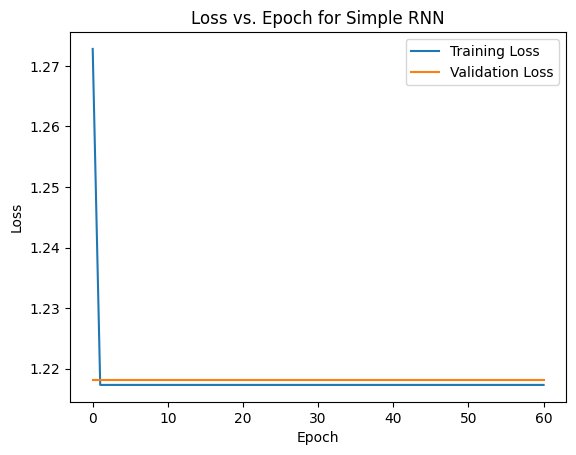

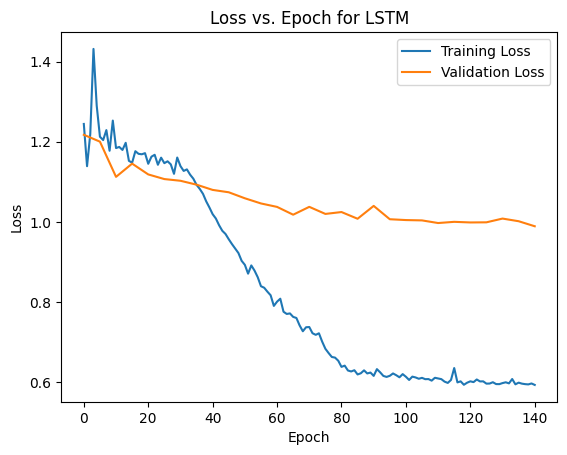

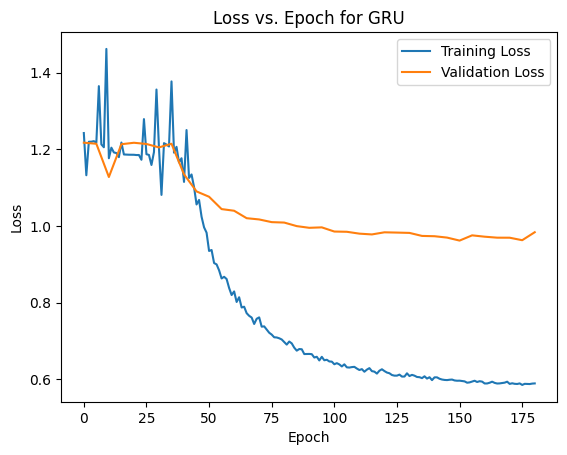

In [6]:
from math import e
from torch import optim
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split

# indices = np.arange(np.shape(transformed_dat)[0])
# np.random.shuffle(indices)
# train_x = torch.tensor(transformed_dat[indices[:int(len(indices)*0.6)]], dtype = torch.long)
# train_y = torch.tensor(transformed_y[indices[:int(len(indices)*0.6)]], dtype = torch.long)
# val_x = torch.tensor(transformed_dat[indices[int(len(indices)*0.6):int(len(indices)*0.8)]], dtype = torch.long)
# val_y = torch.tensor(transformed_y[indices[int(len(indices)*0.6):int(len(indices)*0.8)]], dtype = torch.long)
# test_x = torch.tensor(transformed_dat[indices[int(len(indices)*0.8):]], dtype = torch.long)
# test_y = torch.tensor(transformed_y[indices[int(len(indices)*0.8):]], dtype = torch.long)
comments = df['Cleaned_Text']
labels = np.array(df['Sentiment'])
labels[labels == 'positive'] = 2
labels[labels == 'neutral'] = 1
labels[labels == 'negative'] = 0
labels = np.array(labels, dtype=np.uint8)
comments = np.array(comments)

tokenized_comments = [comment.split() for comment in comments]
vocab = set([word for comment in tokenized_comments for word in comment])
vocab = {word: idx+1 for idx, word in enumerate(vocab)}  # idx+1 to reserve 0 for padding
vocab['<PAD>'] = 0

# Padding
def pad_sequences(tokenized_comments, max_len=100):
    padded = []
    for comment in tokenized_comments:
        if len(comment) > max_len:
            padded.append(comment[:max_len])
        else:
            padded.append(comment + ['<PAD>'] * (max_len - len(comment)))
    return padded

padded_comments = pad_sequences(tokenized_comments)

# Encoding
encoded_comments = [[vocab[word] for word in comment] for comment in padded_comments]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(encoded_comments, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)
X_train, y_train = load_dataset(np.array(X_train), y_train)
X_val, y_val = load_dataset(np.array(X_val), y_val)
X_test, y_test = load_dataset(np.array(X_test), y_test)
X_train = torch.tensor(X_train, dtype = torch.long)
X_test = torch.tensor(X_test, dtype = torch.long)
X_val = torch.tensor(X_val, dtype = torch.long)
y_val = torch.tensor(y_val, dtype = torch.long)
y_train = torch.tensor(y_train, dtype = torch.long)
y_test = torch.tensor(y_test, dtype = torch.long)

epochs = 300
batch_size = 32
val_epoch = 5
load_pretrained = True
train_l_rnn, val_l_rnn, test_pred_rnn, train_l_lstm, val_l_lstm, test_pred_lstm, train_l_gru, val_l_gru, test_pred_gru = None, None, None, None, None, None, None, None, None

if load_pretrained:
  model = myRNN(len(vocab), 100, 128, 3)
  optimizer = optim.AdamW(model.parameters(), lr = 0.001)
  checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/Simple_RNN.pt")
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  train_l_rnn, val_l_rnn = checkpoint['train_losses'], checkpoint['valid_losses']
  model.eval()
  with torch.no_grad():
    test_pred_rnn = model(X_test)

  model = myLSTM(len(vocab), 100, 128, 3)
  optimizer = optim.AdamW(model.parameters(), lr = 0.001)
  checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/LSTM.pt")
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  train_l_lstm, val_l_lstm = checkpoint['train_losses'], checkpoint['valid_losses']
  model.eval()
  with torch.no_grad():
    test_pred_lstm = model(X_test)

  model = myGRU(len(vocab), 100, 128, 3)
  optimizer = optim.AdamW(model.parameters(), lr = 0.001)
  checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/GRU.pt")
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  train_l_gru, val_l_gru = checkpoint['train_losses'], checkpoint['valid_losses']
  model.eval()
  with torch.no_grad():
    test_pred_gru = model(X_test)

else:
  model = myRNN(len(vocab), 100, 128, 3)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.AdamW(model.parameters(), lr = 0.001)
  train_l_rnn, val_l_rnn, test_pred_rnn = train(model, loss_fn, optimizer, X_train, y_train, X_val, y_val, X_test, epochs, val_epoch, 'Simple_RNN')
  print("-========= Done with simple RNN! ==========- \n")

  model = myLSTM(len(vocab), 100, 128, 3)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.AdamW(model.parameters(), lr = 0.001)
  train_l_lstm, val_l_lstm, test_pred_lstm = train(model, loss_fn, optimizer, X_train, y_train, X_val, y_val, X_test, epochs, val_epoch, 'LSTM')
  print("-========= Done with LSTM! ==========- \n")

  model = myGRU(len(vocab), 100, 128, 3)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.AdamW(model.parameters(), lr = 0.001)
  train_l_gru, val_l_gru, test_pred_gru = train(model, loss_fn, optimizer, X_train, y_train, X_val, y_val, X_test, epochs, val_epoch, 'GRU')
  print("-========= Done with GRU! ==========- \n")





pred = np.argmax(test_pred_rnn, axis=1)
print("\nSimple RNN Test metrics:")
print("f1 score: {:.5f}".format(f1_score(y_test, pred, average='macro')))
print("recall score: {:.5f}".format(recall_score(y_test, pred, average='macro')))
print("precision score: {:.5f}".format(precision_score(y_test, pred, average='macro')))
print("Overall accuracy: {:.2f}%".format(accuracy_score(y_test, pred)*100))

pred = np.argmax(test_pred_lstm, axis=1)
print("\nLSTM Test metrics:")
print("f1 score: {:.5f}".format(f1_score(y_test, pred, average='macro')))
print("recall score: {:.5f}".format(recall_score(y_test, pred, average='macro')))
print("precision score: {:.5f}".format(precision_score(y_test, pred, average='macro')))
print("Overall accuracy: {:.2f}%".format(accuracy_score(y_test, pred)*100))

pred = np.argmax(test_pred_gru, axis=1)
print("\nGRU Test metrics:")
print("f1 score: {:.5f}".format(f1_score(y_test, pred, average='macro')))
print("recall score: {:.5f}".format(recall_score(y_test, pred, average='macro')))
print("precision score: {:.5f}".format(precision_score(y_test, pred, average='macro')))
print("Overall accuracy: {:.2f}%".format(accuracy_score(y_test, pred)*100))


plt.plot(np.arange(len(train_l_rnn)), train_l_rnn, label="Training Loss")
plt.plot(np.arange(len(train_l_rnn), step=val_epoch), val_l_rnn, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch for Simple RNN")
plt.show()

plt.plot(np.arange(len(train_l_lstm)), train_l_lstm, label="Training Loss")
plt.plot(np.arange(len(train_l_lstm), step=val_epoch), val_l_lstm, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch for LSTM")
plt.show()

plt.plot(np.arange(len(train_l_gru)), train_l_gru, label="Training Loss")
plt.plot(np.arange(len(train_l_gru), step=val_epoch), val_l_gru, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch for GRU")
plt.show()

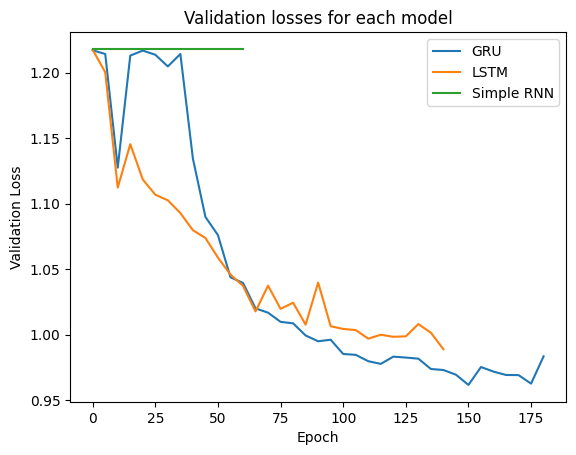

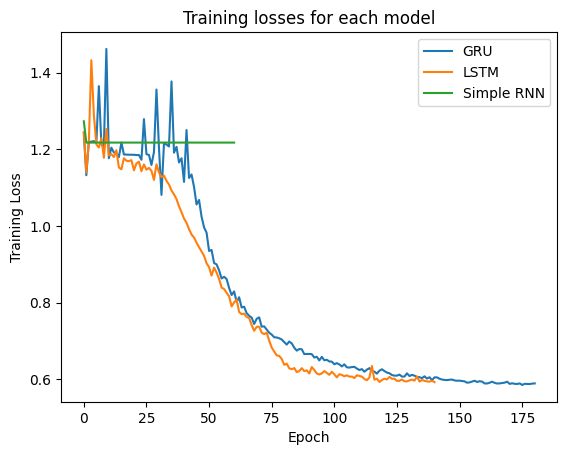

In [7]:
plt.plot(np.arange(len(train_l_gru), step=val_epoch), val_l_gru, label="GRU")
plt.plot(np.arange(len(train_l_lstm), step=val_epoch), val_l_lstm, label="LSTM")
plt.plot(np.arange(len(train_l_rnn), step=val_epoch), val_l_rnn, label="Simple RNN")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation losses for each model")
plt.show()


plt.plot(np.arange(len(train_l_gru)), train_l_gru, label="GRU")
plt.plot(np.arange(len(train_l_lstm)), train_l_lstm, label="LSTM")
plt.plot(np.arange(len(train_l_rnn)), train_l_rnn, label="Simple RNN")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training losses for each model")
plt.show()

In [8]:
!git clone https://github.com/facebookresearch/fastText.git
!sudo pip install ./fastText

Cloning into 'fastText'...
remote: Enumerating objects: 3998, done.
remote: Counting objects: 100% (1024/1024), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 3998 (delta 916), reused 851 (delta 851), pack-reused 2974 (from 2)
Receiving objects: 100% (3998/3998), 8.30 MiB | 32.69 MiB/s, done.
Resolving deltas: 100% (2528/2528), done.
Processing ./fastText
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp311-cp311-linux_x86_64.whl size=4313389 sha256=a6b8d2cd07edd21f029f355585fc747bcbaf72562969a949b31ea14a6d00b8a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-obh_teb4/wheels/1e/bc/93/e4d717605b2816cf84bf6796e766c05fcc2fd4feb3f170fdf3
Successfully built fasttext


In [ ]:
import fasttext
import fasttext.util

def cosine_similarity(w1, w2, ft):
  v1 = ft.get_word_vector(w1)
  v2 = ft.get_word_vector(w2)
  return np.dot(v1, v2)/(np.sqrt(np.sum(v1**2))*np.sqrt(np.sum(v2**2)))

fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')


w1 = input("Input first word: ")
w2 = input("Input second word: ")

print(ft.get_word_vector(w1))
print(ft.get_word_vector(w2))

print("Cosine similarity: {:.5f}".format(cosine_similarity(w1, w2, ft)))


Input first word: hello


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -o glove.6B.zip

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

label_encoder = LabelEncoder()
df["Sentiment"] = label_encoder.fit_transform(df["Sentiment"])

# Tokenizer parameters for vocabulary size and maximum sequence length
max_words = 7500
max_length = 60

X = df["Cleaned_Text"]
y = df["Sentiment"]

# Initialize tokenizer and learn word index mapping from dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)

# Convert text into numerical sequences
X_sequences = tokenizer.texts_to_sequences(X)

# Apply padding to standardize input lengths
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding="post", truncating="post")

print(X_padded)

# Load pretrained GloVe embeddings for improve word representation
embedding_index = {}
with open("glove.6B.300d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0] # Extract the word
        coefs = np.asarray(values[1:], dtype="float32") # Convert embedding values to float
        embedding_index[word] = coefs # Store word and corresponding vector

# Create embedding matrix for the model
embedding_matrix = np.zeros((min(len(tokenizer.word_index) + 1, max_words), 300))
for word, i in tokenizer.word_index.items():
    if i < max_words: # Only include words within the specified vocabulary size
        embedding_vector = embedding_index.get(word) # Retrieve the pre-trained GloVe vector for the word
        if embedding_vector is not None: # If word exists in GloVe embeddings
            embedding_matrix[i] = embedding_vector # Assign the embedding vector to the matrix